In [1]:
import config_readwrite as crw
import itertools

import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd

from scipy import stats
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

import plot_params as pp
pp.fonts()

LOCAL=False

In [2]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

cfn

'/wynton/home/ahituv/fongsl/EMF/US/config.ini'

In [3]:
if LOCAL is True:
    section = 'data'
else:
    section = "mpra"

# load data

In [4]:
CL = "HEPG2"
DATAHEPG2 = config[section][f'{CL}.clean.transformed'] 

CL = "BJ"
DATABJ = config[section][f'{CL}.clean.transformed'] 


RE = "/wynton/home/ahituv/fongsl/EMF/US/results/mpra/eda/pca"

MERGE = False
ACTIVE_ONLY = True

## functions

In [5]:
def openAndFilter(file_name, cl=None, activity=False):
    df = pd.read_csv(file_name, sep='\t').dropna()  # (58333, 38)
    print("before filtering", file_name,  df.shape)

    df = df.loc[(~df["label"].str.contains("Synthetic")) &
                (~df["label"].str.contains("PosC")) &
                (~df["label"].str.contains("Neg"))
                ].reset_index(drop=True)  # (26803, 38)
    print("filter out synthetics, positive, negative controls", df.shape)

    if cl is not None:
        # keep only cl-nominated elements
        df = df.loc[df["name"].str.contains(cl.lower())].copy()

        print("keep only", cl, "elements", df.shape, '\n\n')

    if activity is True:
        df = df.loc[(df["label.ctrl"] != 0) |
                    (df["label.us"] != 0)].copy()  # keep only elements w/ activity > 95PI

        print("keep only", cl, "elements", df.shape, '\n\n')

    return df

# relabel h3k27ac in type column


def relabelH3K27(df):
    df.loc[df.label.str.contains("27"), "type"] = "h3k27ac"
    return df

# label direction and change between US and CTRL


def labelDirection(df):
    """label sequences with different directions of change between US and Control
    note

    negative.higherUS == US MPRA activity is negative, but less negative than CTRL MPRA activity, which is also negative
    positive.higherUS  == US MPRA activity is positive and more positive than CTRL MPRA activity, which is also positive. 
    Positive.negatibe.higherUS == US activity is positive and higher than CTRL MPRA activity, which is negative. 
    """
    df["direction"] = None

    # Positive values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Positive.higherUS"

    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Positive.higherCTRL"

    # Negtaive values only
    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Negative.higherUS"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Negative.higherCTRL"

    # crossing zero values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Positive.Negative.higherUS"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Positive.Negative.higherCTRL"

    print(df.loc[df["direction"] != None, ["l2.ratio.mean.ctrl",
          "l2.ratio.mean.us", 'delta.mean', "direction"]].sample(n=20))
    return df


def labelActivity(df):
    """ label sequences as active if both conditions are positive"""
    df["activity"] = "~l2"
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0),
           "activity"] = "l2>0"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0),
           "activity"] = "l2<0"

    print(df.groupby(["activity"])["name"].count())
    return df

## read data

In [6]:
if MERGE is True:
    """keep all oligos, whether cell type specific or not"""
    hepg2 = openAndFilter(DATAHEPG2)
    bj = openAndFilter(DATABJ)
    
    joint = set(hepg2["name"]).intersection(set(bj["name"]))
    print("joint elements to measure", len(joint))

    # keep only data that is in both 
    hepg2 = hepg2.loc[hepg2["name"].isin(joint)]

    bj = bj.loc[bj["name"].isin(joint)]
    print(bj.shape)

else:
    """keep only cell-specific oligos"""
    
    hepg2 = openAndFilter(DATAHEPG2, "HEPG2", ACTIVE_ONLY)
    bj = openAndFilter(DATABJ, "BJ", ACTIVE_ONLY)

before filtering /wynton/group/ahituv/fongsl/projects/US/data/full_hepg2_MPRA.clean.transformed.csv (11549, 34)
filter out synthetics, positive, negative controls (11549, 34)
keep only HEPG2 elements (4363, 34) 


keep only HEPG2 elements (1655, 34) 


before filtering /wynton/group/ahituv/fongsl/projects/US/data/full_bj_MPRA.clean.transformed.csv (11416, 38)
filter out synthetics, positive, negative controls (11416, 38)
keep only BJ elements (985, 38) 


keep only BJ elements (313, 38) 




In [7]:
for df in [bj, hepg2]:
    df = relabelH3K27(df)
    df = labelDirection(df)
    df = labelActivity(df)
    

       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean            direction
6389             0.331770          0.401126    0.069357    Positive.higherUS
2262            -1.253702         -1.375140   -0.121438  Negative.higherCTRL
822              0.317957          0.470761    0.152804    Positive.higherUS
5794             0.361036          0.333159   -0.027877  Positive.higherCTRL
2538             0.374091          0.144158   -0.229934  Positive.higherCTRL
9418            -1.398783         -1.348727    0.050056    Negative.higherUS
3691             0.294325          0.345614    0.051290    Positive.higherUS
9531             0.490166          0.500151    0.009985    Positive.higherUS
4620             0.436722          0.499911    0.063189    Positive.higherUS
8633             0.403016          0.420893    0.017877    Positive.higherUS
10694            0.381998          0.384906    0.002908    Positive.higherUS
9169             0.492877          0.515945    0.023068    Positive.higherUS

In [8]:
bj.groupby(["label.ctrl", "label.us"])["name"].count()

label.ctrl  label.us
-1          -1           35
             0            3
 0          -1            5
             1           32
 1           0           54
             1          184
Name: name, dtype: int64

In [9]:
hepg2.groupby(["label.ctrl", "label.us"])["name"].count()

label.ctrl  label.us
-1          -1           105
             0            14
 0          -1            22
             1           220
 1           0           268
             1          1026
Name: name, dtype: int64

# long-form PCA analysis
- samples are columns, oligos are rows

In [10]:
"""
X = df[['l2.ratio.1.ctrl',
        'l2.ratio.2.ctrl',
        'l2.ratio.3.ctrl',
        'l2.ratio.1.us',
        'l2.ratio.2.us',
        'l2.ratio.3.us']].copy().to_numpy()

ylabels = df[["label", "response", "cl.origin", "type", "delta.mean", "direction", "activity",
             'pval',
             'p_adj',
             'logFC',
             'response',]]


## scale data

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

## do PCA on scaled data

pca = PCA(n_components=4)
X_ = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_) 

## combine PCA and labels

plot=pd.DataFrame(X_)
plot = pd.concat([plot,ylabels], axis=1)
set(ylabels)

x, y = 0,1
hue='activity'
hue_order = None
fig, ax= plt.subplots()
sns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8)
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")

x, y = 0,1
hue='type'
hue_order = ['ATAC', 'DEG', 'NegCt', 
             #'PosCt', 
             'Shuffle', "h3k27ac"]
fig, ax= plt.subplots()
sns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8)
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")

x, y = 1,2
hue='delta.mean'
fig, ax= plt.subplots()
sns.scatterplot(x=x,y=y, data=plot, hue=hue, alpha=0.8, palette="bwr", hue_order=hue_order)
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor =(1,1))

x, y = 2,3
hue = 'direction'
hue_order = ['Positive.higherUS', 
             'Negative.higherUS',
             'Positive.Negative.higherUS',
             'Positive.higherCTRL', 
             'Negative.higherCTRL',
             'Positive.Negative.higherCTRL',
             
            ]
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=plot, hue=hue, alpha=0.8, hue_order=hue_order, palette = plt.cm.tab20b.colors[9:])
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
       ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor =(1,1))

x, y = 2, 3
hue = 'pval'
hue_order=None
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=plot, hue=hue, alpha=0.8, hue_order=hue_order)
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
       ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor =(1,1))

x, y = 2, 3
hue = 'direction'
hue_order = ['Positive.higherUS',
             'Negative.higherUS',
             'Positive.Negative.higherUS',
             'Positive.higherCTRL',
             'Negative.higherCTRL',
             'Positive.Negative.higherCTRL',
             ]
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=plot, hue=hue, alpha=0.8,
                hue_order=hue_order, palette=plt.cm.tab20b.colors[1:])
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
       ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor=(1, 1))

x, y = 1, 2
hue = 'delta.mean'
# hue = "direction"
hue_order = None
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=plot, hue=hue, alpha=0.8, palette='bwr')
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
       ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor=(1, 1))
"""

'\nX = df[[\'l2.ratio.1.ctrl\',\n        \'l2.ratio.2.ctrl\',\n        \'l2.ratio.3.ctrl\',\n        \'l2.ratio.1.us\',\n        \'l2.ratio.2.us\',\n        \'l2.ratio.3.us\']].copy().to_numpy()\n\nylabels = df[["label", "response", "cl.origin", "type", "delta.mean", "direction", "activity",\n             \'pval\',\n             \'p_adj\',\n             \'logFC\',\n             \'response\',]]\n\n\n## scale data\n\nsc = StandardScaler()\nX_scaled = sc.fit_transform(X)\n\n## do PCA on scaled data\n\npca = PCA(n_components=4)\nX_ = pca.fit_transform(X_scaled)\n\nprint(pca.explained_variance_ratio_) \n\n## combine PCA and labels\n\nplot=pd.DataFrame(X_)\nplot = pd.concat([plot,ylabels], axis=1)\nset(ylabels)\n\nx, y = 0,1\nhue=\'activity\'\nhue_order = None\nfig, ax= plt.subplots()\nsns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8)\nax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", \n      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio

# wide-form PCA analysis
    - samples are rows, oligos are columns

## prepare the data with replicates

In [11]:
# make x and y
cols = ['l2.ratio.1.ctrl',
        'l2.ratio.2.ctrl',
        'l2.ratio.3.ctrl',
        'l2.ratio.1.us',
        'l2.ratio.2.us',
        'l2.ratio.3.us']

xcols = ["name"] + cols

Xbj = bj[xcols].copy()

Xhepg2 = hepg2[xcols].copy()

yhepg2 = ['hepg2-l2.ratio.1.ctrl',
                'hepg2-l2.ratio.2.ctrl',
                'hepg2-l2.ratio.3.ctrl',
                'hepg2-l2.ratio.1.us',
                'hepg2-l2.ratio.2.us',
                'hepg2-l2.ratio.3.us']
ybj = ['bj-l2.ratio.1.ctrl',
           'bj-l2.ratio.2.ctrl',
           'bj-l2.ratio.3.ctrl',
           'bj-l2.ratio.1.us',
           'bj-l2.ratio.2.us',
           'bj-l2.ratio.3.us']



In [12]:
# merge, transpose, and turn into a numpy array.
CL ="BJ"
if MERGE is True:
    X = pd.merge(Xbj, Xhepg2, left_on="name", right_on="name").T.to_numpy()
    y = yhepg2 + ybj
elif CL == 'BJ':
    X = Xbj.set_index("name").T
    y = ybj
elif CL == 'HEPG2':
    X = Xhepg2.set_index("name").T
    y = yhepg2

## scale, fit transform data

In [13]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=3))])
X_ = pipe.fit_transform(X)
pca = pipe.named_steps["pca"]
print(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()) 

[0.27293752 0.22058276 0.18335972] 0.6768799976811289


## scree plot

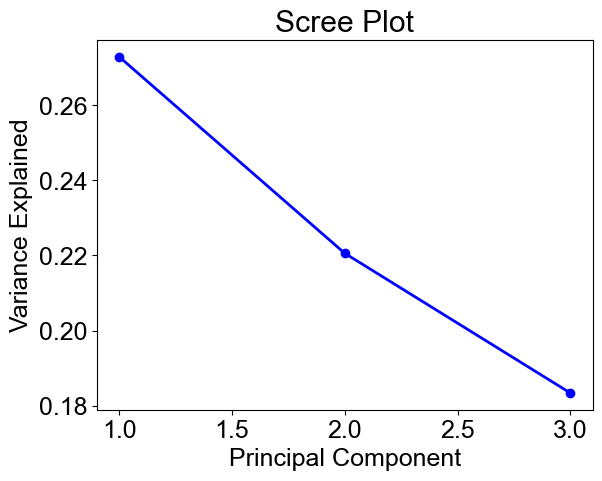

In [14]:
# from https://www.statology.org/scree-plot-python/

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [15]:
# make dataframe from result PCs
plot=pd.DataFrame(X_)

## combine PCA and labels
plot.index = y
plot = plot.reset_index()
plot

,index,0,1,2
0,bj-l2.ratio.1.ctrl,-2.265634,10.748442,1.539155
1,bj-l2.ratio.2.ctrl,-5.218044,-3.907675,14.032854
2,bj-l2.ratio.3.ctrl,-8.488595,9.297838,-7.508142
3,bj-l2.ratio.1.us,18.617164,3.188482,2.233015
4,bj-l2.ratio.2.us,4.065635,-9.852139,-9.065591
5,bj-l2.ratio.3.us,-6.710527,-9.474948,-1.231290


In [16]:
grey = "#929591"
black = "#000000"
toxic_green= "#61de2a"
dark_grass_green = "#388004"
electric_lime="#a8ff04"
deep_lilac="#966ebd"
eggplant = '#430541'
        
cmap = [grey]*3 + [black]*3

## pcM v. pcN

<Axes: >

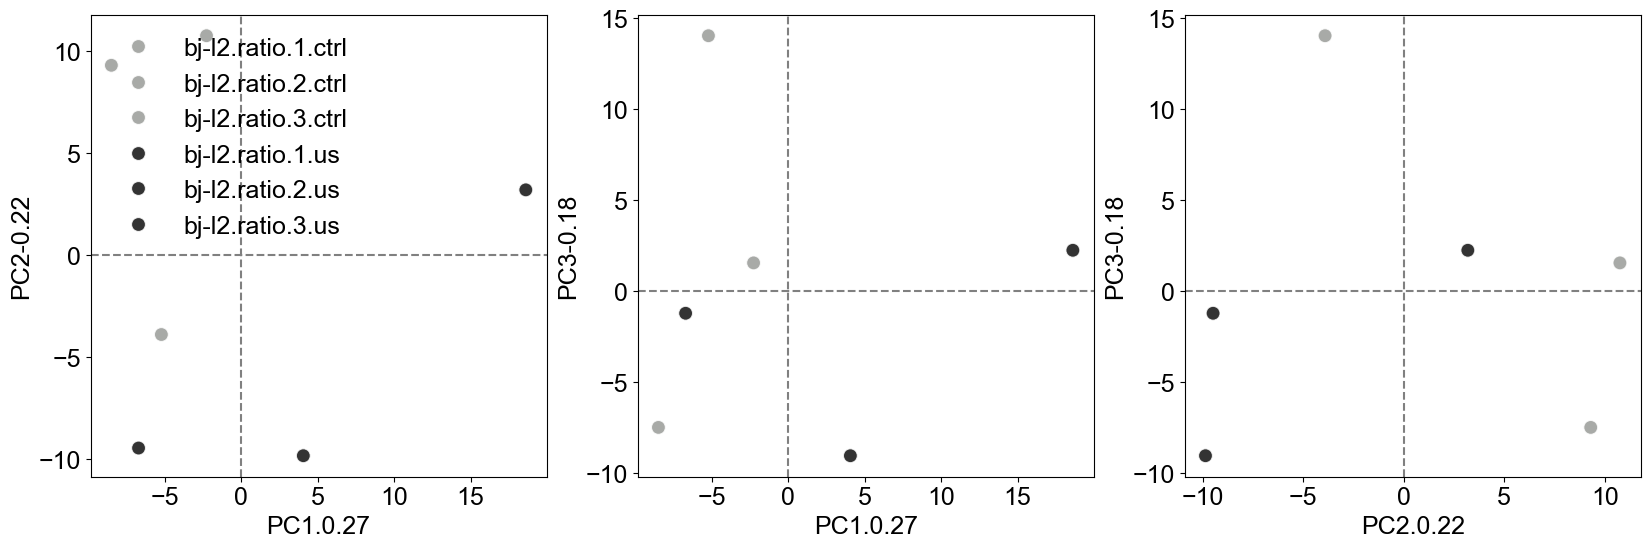

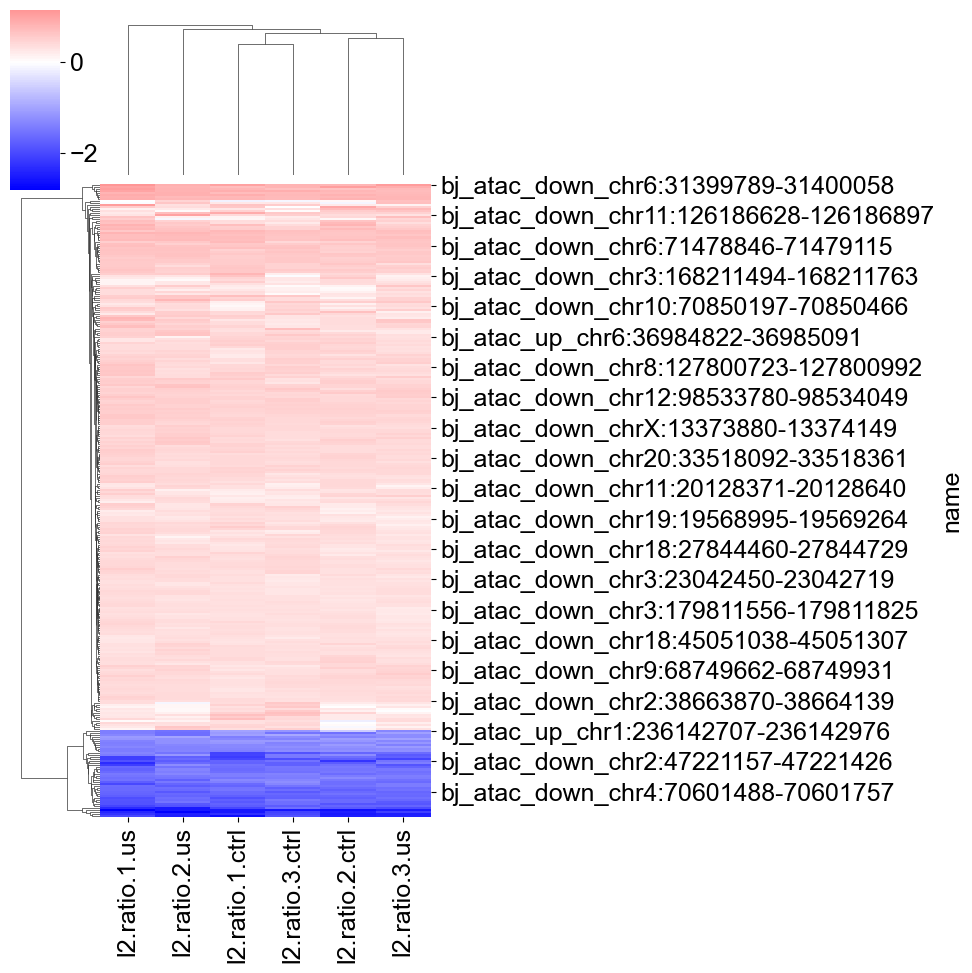

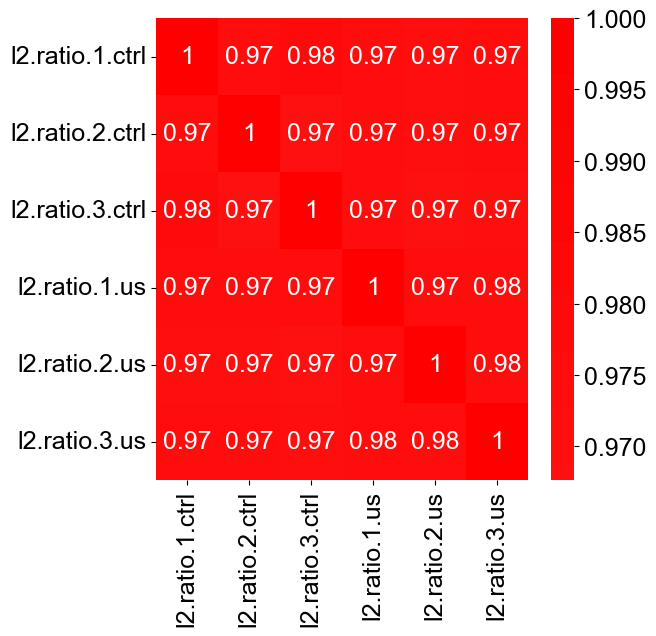

In [17]:
combos = itertools.combinations(np.arange(pca.n_components), 2)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (20,6))
ax_list = [ax1, ax2, ax3]

i=0
for x,y in combos:

    hue="index"
    hue_order = None
    ax=ax_list[i]

    sns.scatterplot(x=x,y=y, data=plot, 
                    hue=hue, hue_order=hue_order, alpha=0.8, palette=cmap,
                    s=100, ax=ax
                   )
    ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
          ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
    ax.axhline(0, ls="--", color="grey")
    ax.axvline(0, ls="--", color="grey")
    if i==0:
        ax.legend(loc='upper left', #bbox_to_anchor =(1,1), 
                  frameon=False)
    else:
        ax.legend(bbox_to_anchor =(1,1), frameon=False).remove()
    i+=1

if ACTIVE_ONLY is True:
    
    outpca = os.path.join(RE, f"pca-{pca.n_components}pcs_{CL}.active_only.pdf")
    outcluster = os.path.join(RE, f"clustermap.{CL}.active_only.pdf")
else:
    
    outpca = os.path.join(RE, f"pca-{pca.n_components}pcs_{CL}.all.pdf")
    outcluster =os.path.join(RE, f"clustermap.{CL}.all.pdf")
plt.savefig(outpca, bbox_inches='tight')

sns.clustermap(X.T,  cmap="bwr", center=0)

if ACTIVE_ONLY is True:
    out = os.path.join(RE, f"clustermap.{CL}.active_only.pdf")

else:
    out=os.path.join(RE, f"clustermap.{CL}.all.pdf")

plt.savefig(outcluster, bbox_inches='tight')

fig, ax=plt.subplots(figsize=(6,6))
sns.heatmap(X.T[cols].corr(), cmap="bwr", center=0.5, annot=True)

# PCA on top/bottom 5 elements

In [18]:
N = 50
if CL == 'HEPG2':
    top_bottom = pd.concat([hepg2.sort_values(by="delta.mean").iloc[:N].copy(),
                            hepg2.sort_values(by="delta.mean").iloc[-N:].copy()])

elif CL == 'BJ':
    top_bottom = pd.concat([bj.sort_values(by="delta.mean").iloc[:N].copy(),
                            bj.sort_values(by="delta.mean").iloc[-N:].copy()])

In [19]:
X = top_bottom[cols].T
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=3))])
X_ = pipe.fit_transform(X)
pca = pipe.named_steps["pca"]
print(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()) 

[0.4069131  0.16959397 0.15870776] 0.7352148303476518


In [20]:
# make dataframe from result PCs
plot=pd.DataFrame(X_)

## combine PCA and labels
plot.index = cols
plot = plot.reset_index()
plot

,index,0,1,2
0,l2.ratio.1.ctrl,6.617799,-4.158898,-0.487969
1,l2.ratio.2.ctrl,4.067166,5.933847,5.959131
2,l2.ratio.3.ctrl,7.984133,-1.490014,-3.031403
3,l2.ratio.1.us,-7.754720,-5.455010,4.755824
4,l2.ratio.2.us,-5.885486,1.187310,-4.541146
5,l2.ratio.3.us,-5.028892,3.982766,-2.654436


In [21]:
combos = itertools.combinations(np.arange(pca.n_components), 2)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 6))
ax_list = [ax1, ax2, ax3]

i = 0
for x, y in combos:

    hue = "index"
    hue_order = None
    ax = ax_list[i]

    sns.scatterplot(x=x, y=y, data=plot,
                    hue=hue, hue_order=hue_order, alpha=0.8, palette=cmap,
                    s=100, ax=ax
                    )
    ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
           ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
    ax.axhline(0, ls="--", color="grey")
    ax.axvline(0, ls="--", color="grey")
    if i == 0:
        ax.legend(loc='upper left',  # bbox_to_anchor =(1,1),
                  frameon=False)
    else:
        ax.legend(bbox_to_anchor=(1, 1), frameon=False).remove()
    i += 1

if ACTIVE_ONLY is True:
    outcluster= = os.path.join(RE, f"clustermap.{CL}.top.active_only.pdf")
    outpca = os.path.join(RE, f"pca-{pca.n_components}pcs_{CL}.top.active_only.pdf")
else:
    outcluster =os.path.join(RE, f"clustermap.{CL}.top.all.pdf")
    outpca = os.path.join(RE, f"pca-{pca.n_components}pcs_{CL}.top.all.pdf")

plt.savefig(outpca, , bbox_inches='tight')

sns.clustermap(X.T,
               cmap="bwr", center=0, square=True,
               cbar_kws={"label": "l2(RNA/DNA)"}
               )

plt.savefig(outcluster, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(X.T[cols].corr(), cmap="bwr", center=0.5, annot=True)

SyntaxError: invalid syntax (3631477812.py, line 29)